In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

%matplotlib widget

In [8]:
readings = pd.read_csv("../power_calibration.csv")

In [9]:
df = pd.DataFrame(columns=["frame", "x", "y", "z", "power"])
frames = []
xs = []
ys = []
zs = []
powers = []

# iterate over rows
for frame, grp in readings.groupby("frame"):
    if len(grp) < 4:
        continue
    else:
        # find center of mass for the four points
        xs.append(np.nanmean(grp["x"]))
        ys.append(np.nanmean(grp["y"]))
        zs.append(np.nanmean(grp["z"]))
        powers.append(np.mean(grp["power"]))
        frames.append(frame)

df["frame"] = frames
df["x"] = xs
df["y"] = ys
df["z"] = zs
df["power"] = powers

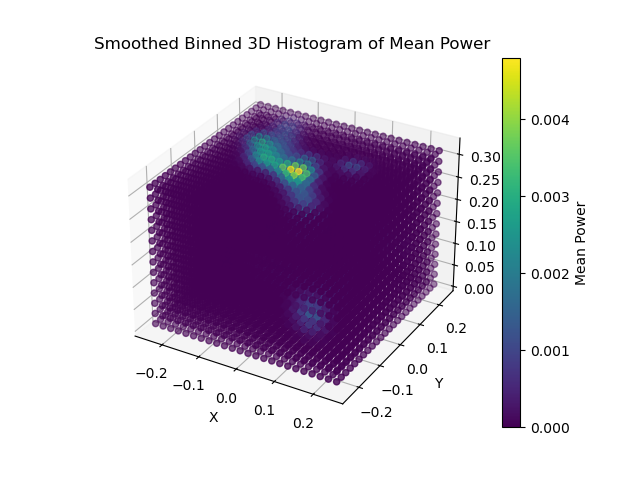

In [15]:
x_bins = np.linspace(-0.25, 0.25, 25)
y_bins = np.linspace(-0.25, 0.25, 25)
z_bins = np.linspace(0, 0.325, 15)

# Convert DataFrame columns to NumPy arrays
xyz = df[["x", "y", "z"]].values

# Bin the data and calculate the mean power for each bin
bin_means, edges = np.histogramdd(
    xyz, bins=[x_bins, y_bins, z_bins], weights=df["power"]
)
bin_counts, _ = np.histogramdd(xyz, bins=[x_bins, y_bins, z_bins])
mean_power = np.divide(
    bin_means, bin_counts, out=np.zeros_like(bin_means), where=bin_counts != 0
)

# Smooth the mean power values
smoothed_power = gaussian_filter(mean_power, sigma=1)

# Plot the 3D histogram
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Create a meshgrid for the bin centers
x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2
z_centers = (z_bins[:-1] + z_bins[1:]) / 2

x_mesh, y_mesh, z_mesh = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")

# Flatten the arrays for plotting
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
z_flat = z_mesh.flatten()
smoothed_power_flat = smoothed_power.flatten()

# Create scatter plot with color mapping to mean power
sc = ax.scatter(
    x_flat, y_flat, z_flat, c=smoothed_power_flat, cmap="viridis", marker="o"
)

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Mean Power")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Smoothed Binned 3D Histogram of Mean Power")

plt.show()